In [9]:
import pandas as pd
import numpy as np
import math
import ipywidgets as widgets

##Seaborn for fancy plots. 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


import geopandas as gpd
from shapely.geometry import Point
#import fiona

plt.rcParams['figure.figsize'] = (20, 9)
plt.style.use('Solarize_Light2')

import folium # mapping
from folium.plugins import HeatMap
import scikit_posthocs as sp

Since all our numerical columns are DISCRETE (Counts), we can perform statistical analyses within and between clusters to investigate relationships between variables. Since the numerical columns are discrete count variables, we can use methods like chi-squared tests, ANOVA, and correlation analysis to assess the relationships between variables.

For example, we could use a chi-squared test to determine if there is a significant association between two categorical variables, such as the association between employment status and severe crime within a specific cluster.

We could also use ANOVA to compare the means of a continuous variable (such as income levels) across different clusters to determine if there are significant differences in income levels between clusters.

Finally, we could use correlation analysis to investigate the relationships between different variables within a cluster or between clusters, such as the correlation between income levels and severe crime within a specific cluster or between different clusters.

However, with a small sample size, it may be difficult to meet the assumptions of normality required for ANOVA. In such cases, non-parametric tests such as the Kruskal-Wallis test may be more appropriate. And also, having small cluster sizes may also be an issue for any statistical analysis. In general, larger sample sizes are better for statistical analysis as they tend to produce more reliable and accurate results.

Chi-squared test also has assumptions regarding the sample size and expected frequencies of the variables. In general, for the Chi-squared test to be reliable, the expected frequencies of each cell should be at least 5, and the sample size should be large enough.

In the case of our dataset, the small sample size and low counts in some categories may not meet the assumptions of the Chi-squared test. Therefore, it may not be the best approach for analyzing the data.

We will use the Kruskal-Wallis test.
The Kruskal-Wallis test is a non-parametric statistical test used to determine if there are significant differences between two or more groups in terms of a continuous or discrete variable. The test compares the medians of the groups and is commonly used when the data does not meet the assumptions of normality required for other parametric tests like the t-test or ANOVA.

In [10]:
final=pd.read_csv('Final_with_clustersV2.csv')
final.drop(['Unnamed: 0'], axis=1, inplace =True)
final.head(5)

,NGH_Name,Assault,Break and Enter,Homicide,Robbery,Sexual Assaults,Theft From Vehicle,Theft Of Vehicle,Theft Over $5000,Latitude,...,Income_30K to less than 60K,Income_60K to less than 100K,Income_100K to less than 125K,Income_125K to less than 150K,Income_150K to less than 200K,Income_200K to less than 250K,Income_250K or more,Income_No Response,Assessed Value,Cluster_KMeans
0,ABBOTTSFIELD,35,8,0,8,4,16,6,0,53.574143,...,170.0,79.0,23.0,4.0,3.0,3.0,2.0,195.0,346340.616967,3
1,ALBANY,8,8,0,2,2,9,2,1,53.632382,...,56.0,63.0,30.0,9.0,14.0,13.0,3.0,350.0,349281.212842,3
2,ALBERTA AVENUE,123,119,1,26,13,156,99,2,53.568485,...,667.0,364.0,139.0,62.0,61.0,11.0,4.0,1138.0,280696.449473,1
3,ALDERGROVE,17,19,0,6,4,46,23,0,53.516888,...,266.0,284.0,135.0,72.0,49.0,22.0,12.0,952.0,368950.794621,0
4,ALLARD,6,17,0,1,0,12,3,4,53.401301,...,48.0,165.0,109.0,48.0,69.0,32.0,23.0,560.0,377596.339603,3


In [11]:
final['Cluster_KMeans'].value_counts()

0    113
3    110
2     11
1      9
Name: Cluster_KMeans, dtype: int64

In [12]:
cluster_0=final[final['Cluster_KMeans']==0]
cluster_1=final[final['Cluster_KMeans']==1]
cluster_2=final[final['Cluster_KMeans']==2]
cluster_3=final[final['Cluster_KMeans']==3]

>## First we will display Pie charts to display the proportions of the crimes by cluster. 

In [13]:
"""Plotting Pie charts for the distribution as a % of each grouped crime by Cluster"""
def plot_violation_type_distribution(data, violation_group):
    # Define the two violation groups
    severe_crime = ['Homicide', 'Assault', 'Robbery', 'Sexual Assaults']
    property_crime = ['Break and Enter', 'Theft From Vehicle', 'Theft Of Vehicle', 'Theft Over $5000']

    # Select the appropriate violation group
    if violation_group == 'Severe Crime':
        violation_types = severe_crime
    elif violation_group == 'Property Crime':
        violation_types = property_crime
    else:
        raise ValueError("Violation group must be 'Severe Crime' or 'Property Crime'.")

    # Calculate the total count of each violation type in each cluster
    cluster_counts = data.groupby('Cluster_KMeans')[violation_types].mean()

    # Create a 2x2 grid of subplots for each cluster
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

    # Loop over each cluster and create a pie chart of the violation type distribution
    for i, ax in enumerate(axs.flat):
        # Get the counts for the current cluster and convert to percentages
        counts = cluster_counts.iloc[i]
        total = counts.sum()
        percents = counts / total * 100

        # Create the pie chart
        labels = percents.index
        sizes = percents.values
        ax.pie(sizes, labels=labels, autopct='%1.1f%%')
        ax.set_title(f'Cluster {i}')
    
    # Add a common title for the whole figure
    fig.suptitle(f'{violation_group} Distribution by Cluster', fontsize=16)
    
    # Set the layout and show the plot
    plt.tight_layout()
    plt.show()

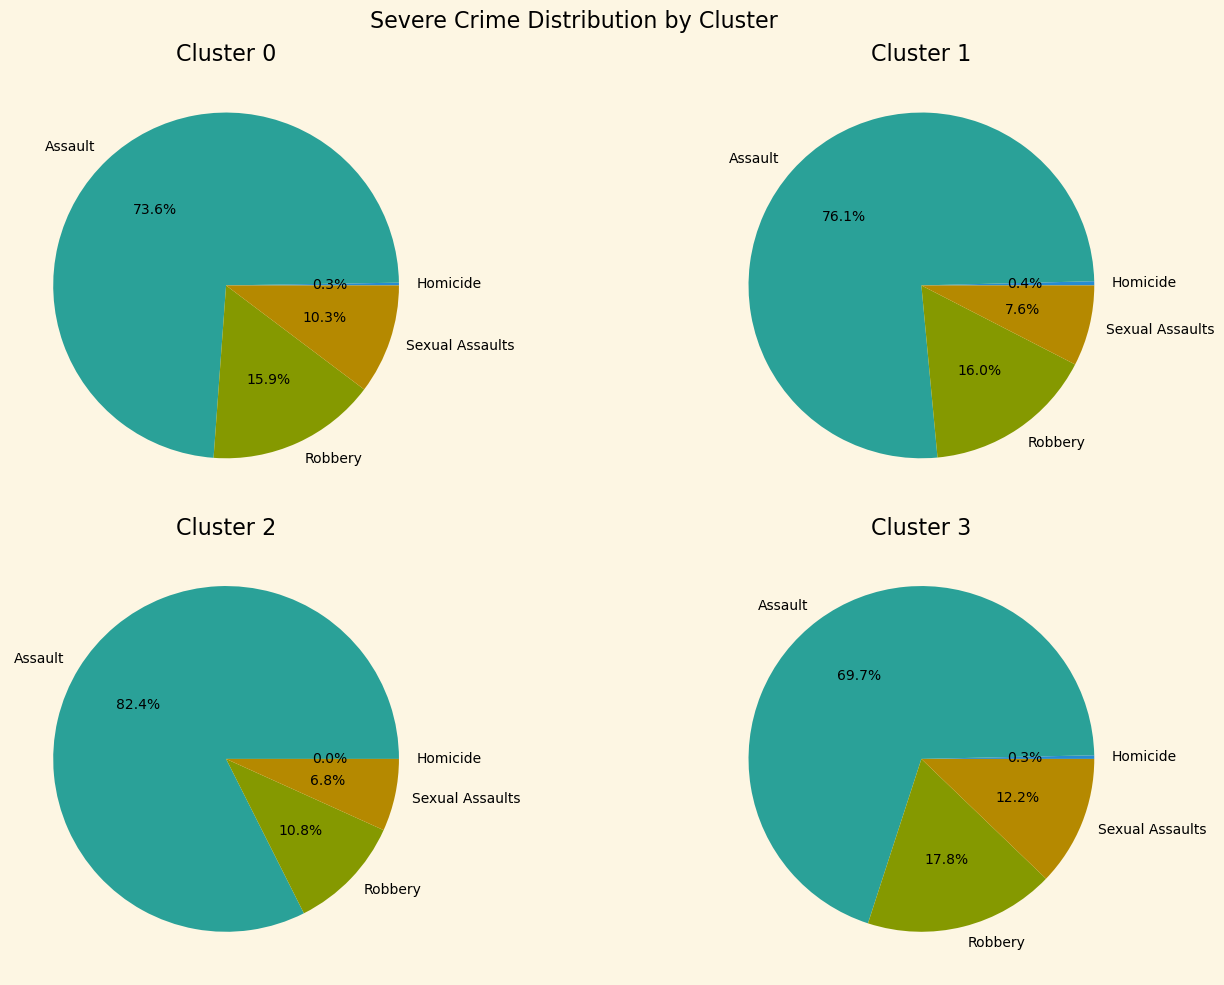

In [14]:
plot_violation_type_distribution(final, "Severe Crime")

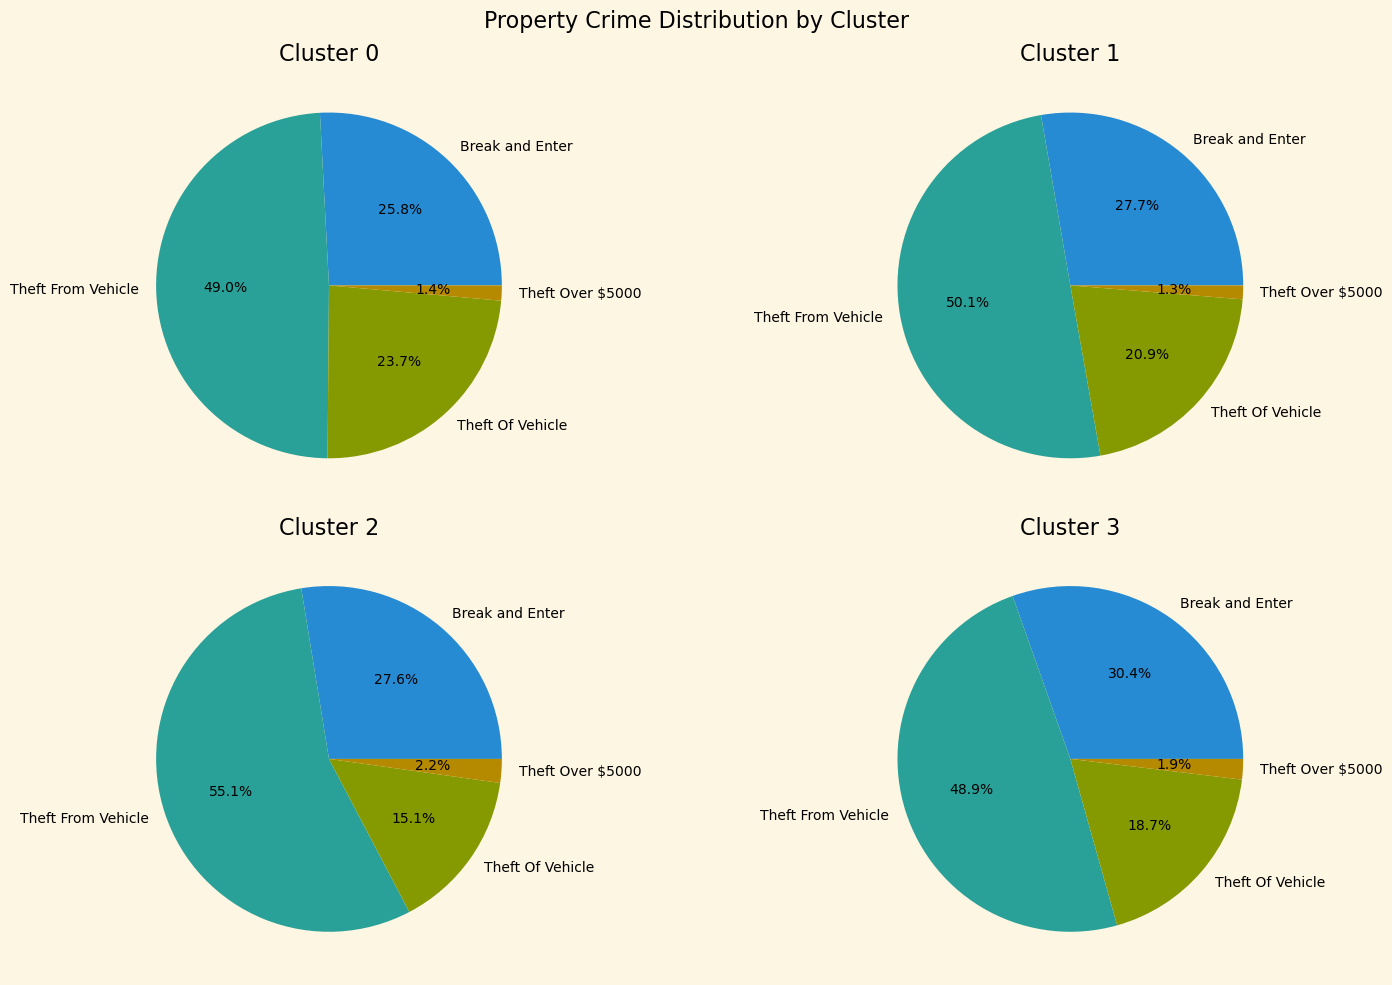

In [15]:
plot_violation_type_distribution(final, "Property Crime")

>## Secondly, we will use Statistical Analysis to show the REAL difference between the clusters, using kruskal_Wallis test.

Define the Hypothesis:
<li>Null Hypothesis= There is no siginificant difference between the clusters when it comes to the specific crimes used in the tests below.
<li> Alpha=0.05

In [16]:
"""The function kruskal_wallis_clusters takes a DataFrame with crime data and performs a Kruskal-Wallis test 
    for each severe and property crime type across the four KMeans clusters. 
    The function first defines two lists, one for the severe crime types and the other for the KMeans clusters. 
    It then creates an empty DataFrame to store the Kruskal-Wallis test statistics and p-values for each severe crime type. 
    The function then iterates through each severe crime type and KMeans cluster and collects the data for each cluster. 
    It then performs the Kruskal-Wallis test on the collected data and adds the results to the DataFrame. 
    The function returns the DataFrame with the Kruskal-Wallis test statistics and p-values for each severe crime type."""
from scipy import stats
from scipy.stats import kruskal

def kruskal_wallis_clusters(data):
    # List of severe crime types
    crimes = ['Assault', 'Break and Enter', 'Homicide', 'Robbery',
       'Sexual Assaults', 'Theft From Vehicle', 'Theft Of Vehicle',
       'Theft Over $5000']
    
    # List of cluster groups
    clusters = [0,1, 2, 3]
    
    # Create empty dataframe to store results
    results = pd.DataFrame(columns=crimes, index=['Kruskal-Wallis Test Statistic', 'P-value'])
    
    for crime in crimes:
        crime_stats = []
        for cluster in clusters:
            cluster_data = data[data['Cluster_KMeans'] == cluster][crime]
            crime_stats.append(cluster_data)
        # Perform Kruskal-Wallis test
        stats, pvalue = kruskal(*crime_stats)
        # Add results to dataframe
        results[crime] = [stats, pvalue]
        
    return results
kruskal_wallis_clusters(final)

,Assault,Break and Enter,Homicide,Robbery,Sexual Assaults,Theft From Vehicle,Theft Of Vehicle,Theft Over $5000
Kruskal-Wallis Test Statistic,9.025974e+01,6.451696e+01,24.489673,5.537088e+01,6.507025e+01,1.028861e+02,1.056089e+02,3.653027e+01
P-value,1.926496e-19,6.363253e-14,0.000020,5.722543e-12,4.845427e-14,3.722515e-22,9.664229e-23,5.784338e-08


An interpretation of the results of the Kruskal-Wallis test for the different severe and property crimes:

<li>Assault, Robbery, Sexual Assaults and Homicide: the Kruskal-Wallis test statistic is higher than the critical value, and the p-value is significantly lower than 0.05. Therefore, we can reject the null hypothesis that there is no difference in the mean number of these crimes across the different clusters. This suggests that the clusters differ significantly in terms of these types of severe crimes.

<li>Break and Enter, Theft from Vehicle, Theft of Vehicle, and Theft over $5000: the Kruskal-Wallis test statistic is higher than the critical value, and the p-value is significantly lower than 0.05. Therefore, we can reject the null hypothesis that there is no difference in the mean number of these property crimes across the different clusters. This suggests that the clusters differ significantly in terms of these types of property crimes.



In general, the results of the Kruskal-Wallis test indicate that the different clusters have different crime patterns in terms of both severe and property crimes. This underscores the importance of analyzing and understanding the specific factors driving crime in each cluster in order to develop effective crime prevention strategies.

Since the variables in the dataframe are counts and the dataframe has a limited number of rows, it may not be appropriate to perform statistical tests between the clusters. This is because the assumptions of normality and independence required for many statistical tests may not hold true for count data. In addition, with a limited number of rows, statistical tests may not have enough power to detect significant differences between the clusters.

>## Finally Create a horizontal Bar Plot to compliment our Statistical Kruskal-Wallis Test, the right way.

C:\Users\azimi\AppData\Local\Temp\ipykernel_18148\3392201399.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  crime_means = final.groupby('Cluster_KMeans')['Assault', 'Break and Enter', 'Homicide', 'Robbery',


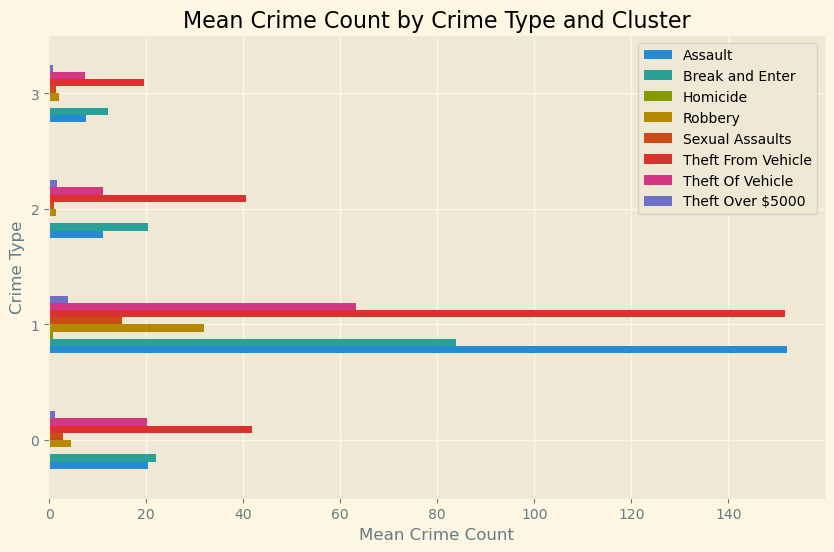

In [17]:
# Get the mean crime count for each crime type for each cluster
crime_means = final.groupby('Cluster_KMeans')['Assault', 'Break and Enter', 'Homicide', 'Robbery',
                                               'Sexual Assaults', 'Theft From Vehicle', 'Theft Of Vehicle',
                                               'Theft Over $5000'].mean()

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
crime_means.plot(kind='barh', ax=ax)

# Set chart title and axis labels
ax.set_title('Mean Crime Count by Crime Type and Cluster')
ax.set_xlabel('Mean Crime Count')
ax.set_ylabel('Crime Type')

# Show the chart
plt.show()

>## Conculusion

It's always good idea to perform a statistical test first to validate any differences between the clusters before relying solely on the proportion pie charts. While the pie charts may show the proportion of crimes within each cluster, it does not take into account the proportion of crimes in the overall dataset. This can lead to misinterpretation of the clusters, as a cluster with a high proportion of a certain crime may not necessarily have a statistically significant difference in that crime compared to other clusters. Therefore, it's important to use both statistical tests and visualization tools like pie charts to gain a more comprehensive understanding of the data.

Comparing Calgary HOT Cluster to Edmonton HOT Cluster: It is not possible to perform a Kruskal-Wallis test on two clusters from two different dataframes. This is because the Kruskal-Wallis test requires the data to be combined into a single dataset, and the samples to be independent and identically distributed. If the clusters are from two different dataframes, they are likely to have different data distributions and may not be independent. Therefore, it is important to perform the Kruskal-Wallis test on the same dataset for all the clusters being compared.